In [16]:
# Read data from CSV file into a DataFrame
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('clean_sub.csv')

# Assuming df is your DataFrame with features and labels
X = df[['country', 'operator', 'service', 'source', 'status', 'cycle', 'adnet',
        'subs_date', 'renewal_date', 'unsubs_from', 'unsubs_date', 'currency',
        'publisher', 'attempt_charging', 'service_price_usd']]
y = df['is_successful']
categorical_features = ['country', 'operator', 'service', 'source', 'status', 'adnet', 'currency', 'publisher', 'cycle']
# Handle DtypeWarning
print(df.iloc[:, 4].unique())  # Check unique values in column 4

# Explicitly use .loc to avoid SettingWithCopyWarning
X.loc[:, categorical_features] = X[categorical_features].astype(str)

# Specify date format to avoid UserWarning
date_columns = ['subs_date', 'renewal_date', 'unsubs_from', 'unsubs_date']
for column in date_columns:
    X[column] = pd.to_numeric(pd.to_datetime(X[column], errors='coerce', format='%Y-%m-%d'))

# Continue with label encoding and model training
# (Ensure you have already run the previous preprocessing steps)
label_encoder = LabelEncoder()
for feature in categorical_features:
    X[feature] = label_encoder.fit_transform(X[feature])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LGBMClassifier
clf = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    num_leaves=31, 
    learning_rate=0.05, 
    n_estimators=100
)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)


# Evaluate the model
accuracy_lgbm = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_lgbm = classification_report(y_test, y_pred)

print(f'Accuracy (Light GBM): {accuracy_lgbm}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_lgbm}')

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


[459505104 459505106 459505105 459509902 459509903 459509901 '459505105'
 '459505106' '459505104' '459509903' '459509902' '459509901' 'gemezz'
 'slypee' 'halogame' 'Halogame' 'goaly']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Number of positive: 58110, number of negative: 188320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 246430, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.235807 -> initscore=-1.175805
[LightGBM] [Info] Start training from score -1.175805
Accuracy (Light GBM): 0.9321841319309181
Confusion Matrix:
[[44710  2364]
 [ 1814 12720]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     47074
           1       0.84      0.88      0.86     14534

    accuracy                           0.93     61608
   macro avg       0.90      0.91      0.91     61608
weighted avg       0.93      0.93      0.93     61608



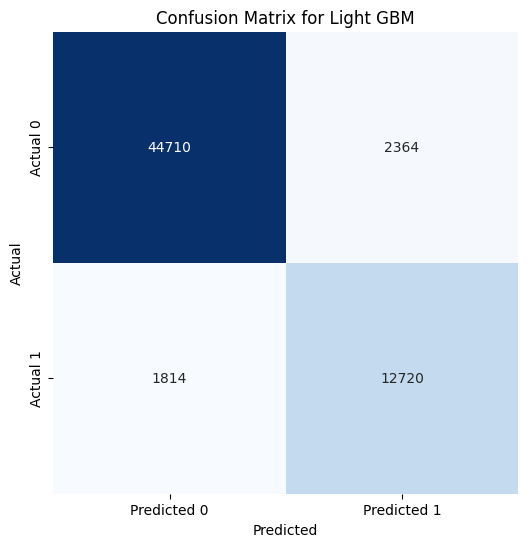

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Light GBM')
plt.show()

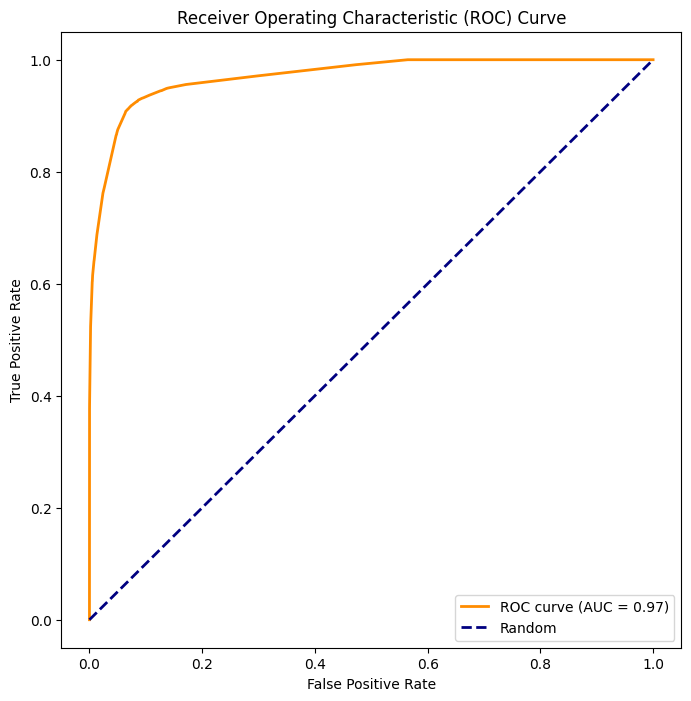

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob= clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

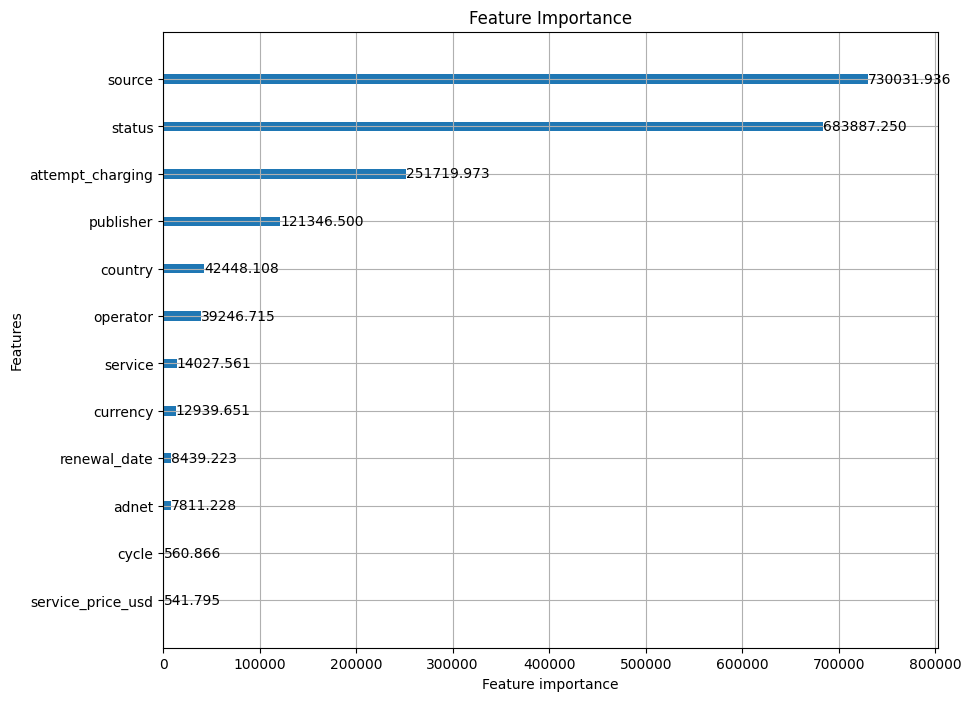

In [19]:
import matplotlib.pyplot as plt

# Plot feature importances
lgb.plot_importance(clf, figsize=(10, 8), importance_type='gain', title='Feature Importance')
plt.show()

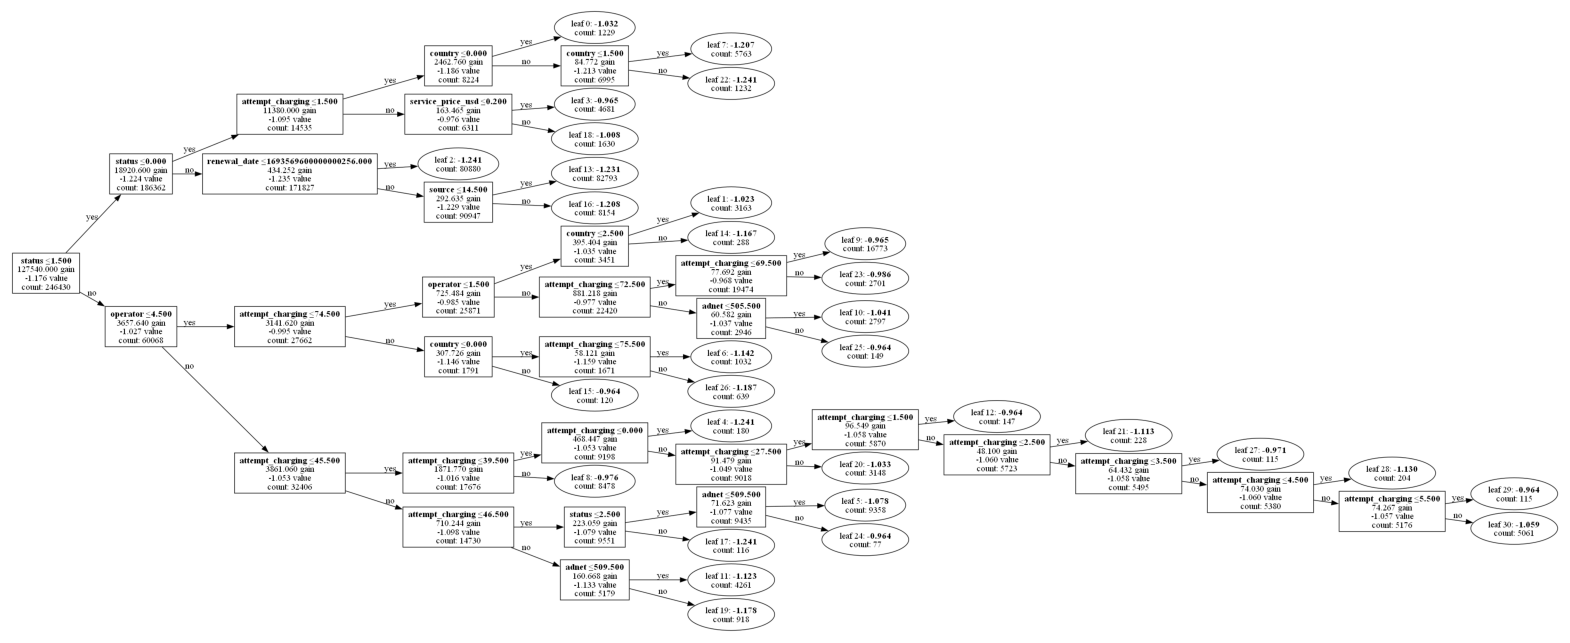

In [20]:
import matplotlib.pyplot as plt

# Assuming clf is your trained LightGBM model
tree_index = 0  # Choose the index of the tree you want to visualize (0 for the first tree)

# Plot the selected tree
lgb.plot_tree(clf, tree_index=tree_index, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'leaf_count', 'internal_count'])
plt.show()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


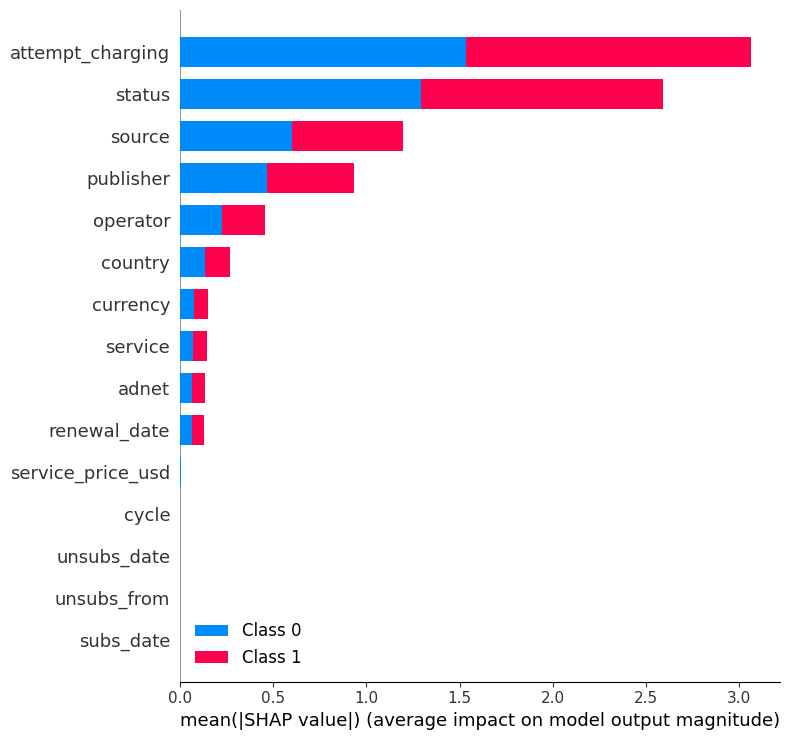

In [21]:
import shap

# Assuming clf is your trained LightGBM classifier
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Visualize the summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

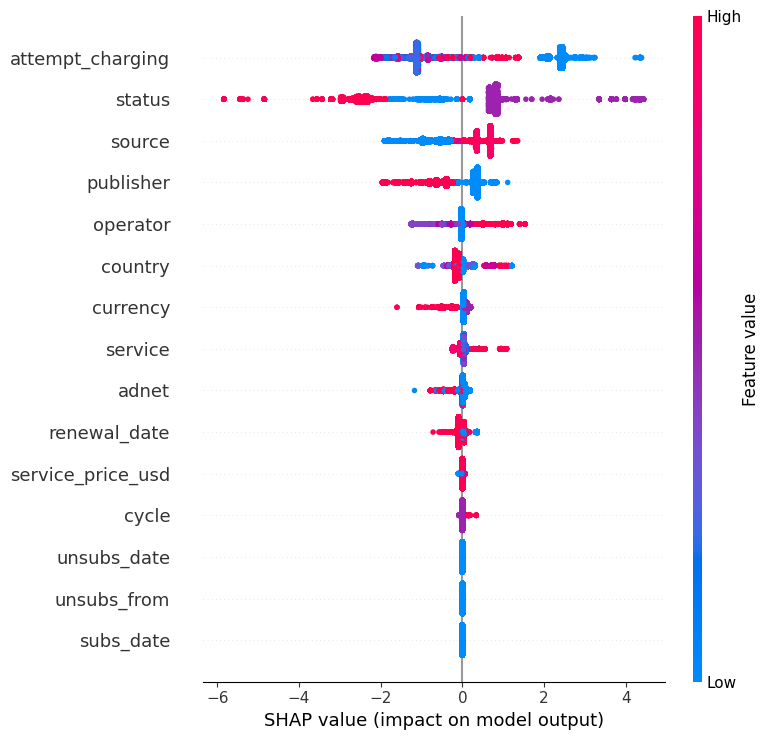

In [22]:
shap.summary_plot(shap_values[0], X_test)

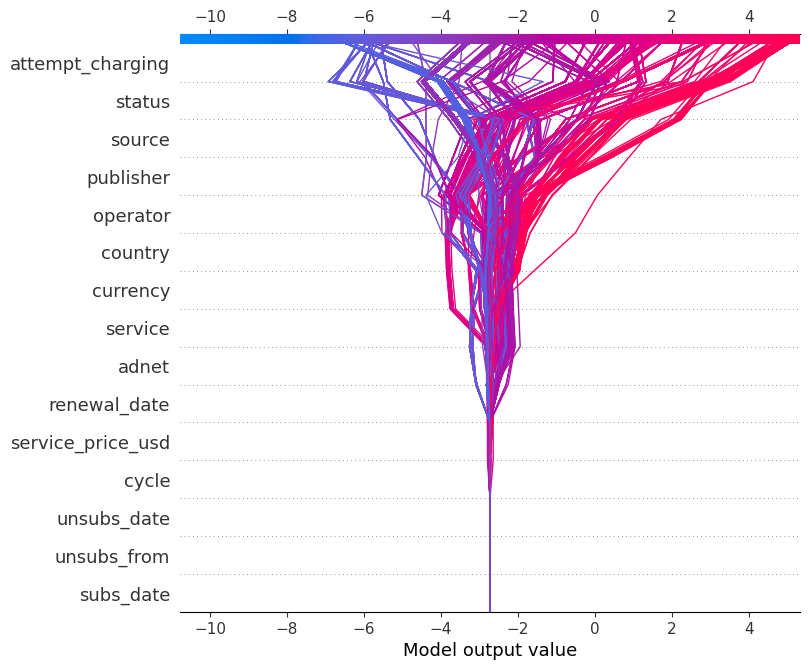

In [29]:
import numpy as np

# Subsample your data
subsample_indices = np.random.choice(X_test.shape[0], size=2000, replace=False)
X_test_subsampled = X_test.iloc[subsample_indices]
shap_values_subsampled = shap_values[1][subsample_indices, :]

# Plot the decision plot with the subsampled data
shap.decision_plot(explainer.expected_value[1], shap_values_subsampled, X_test.columns)

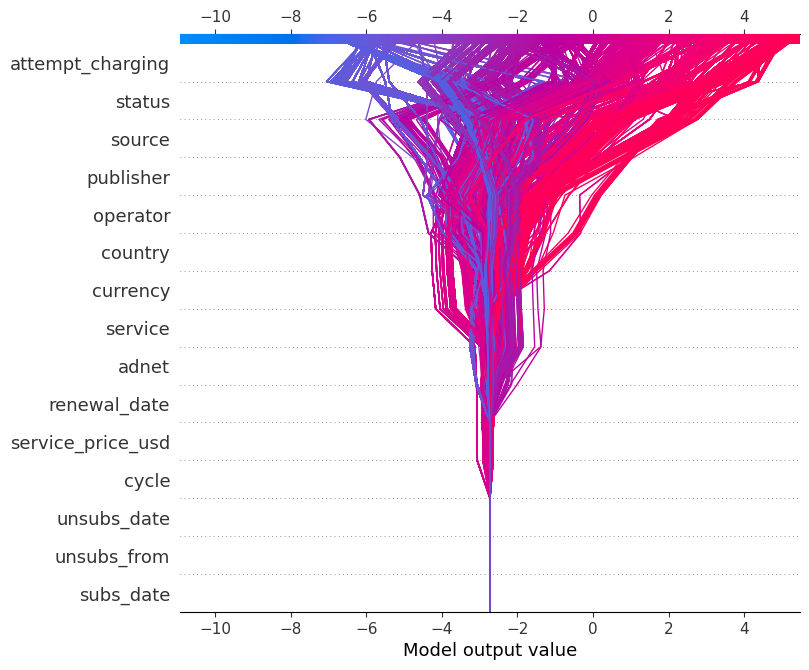

In [30]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns, ignore_warnings=True)

In [32]:
#import shap
#import matplotlib.pyplot as plt
#import seaborn as sns

# Assuming clf is your trained LightGBM classifier
#explainer = shap.TreeExplainer(clf)
#shap_values = explainer.shap_values(X_test)

# Reshape the SHAP values
#shap_values_2d = shap_values[1]  # Assuming you're using binary classification (change index if needed)
#shap_values_2d = shap_values_2d.reshape((shap_values_2d.shape[0], -1))

# Create a DataFrame with SHAP values and feature names
#shap_df = pd.DataFrame(shap_values_2d, columns=X_test.columns)

# Melt the DataFrame to long format for beeswarm plot
#shap_df_melted = pd.melt(shap_df.reset_index(), id_vars=['index'], value_vars=shap_df.columns)

# Create a beeswarm plot using seaborn
#plt.figure(figsize=(12, 8))
#sns.swarmplot(x='value', y='variable', data=shap_df_melted, size=3)
#plt.xlabel('SHAP Value')
#plt.ylabel('Feature')
#plt.title('Beeswarm Plot of SHAP Values for Features')
#plt.show()

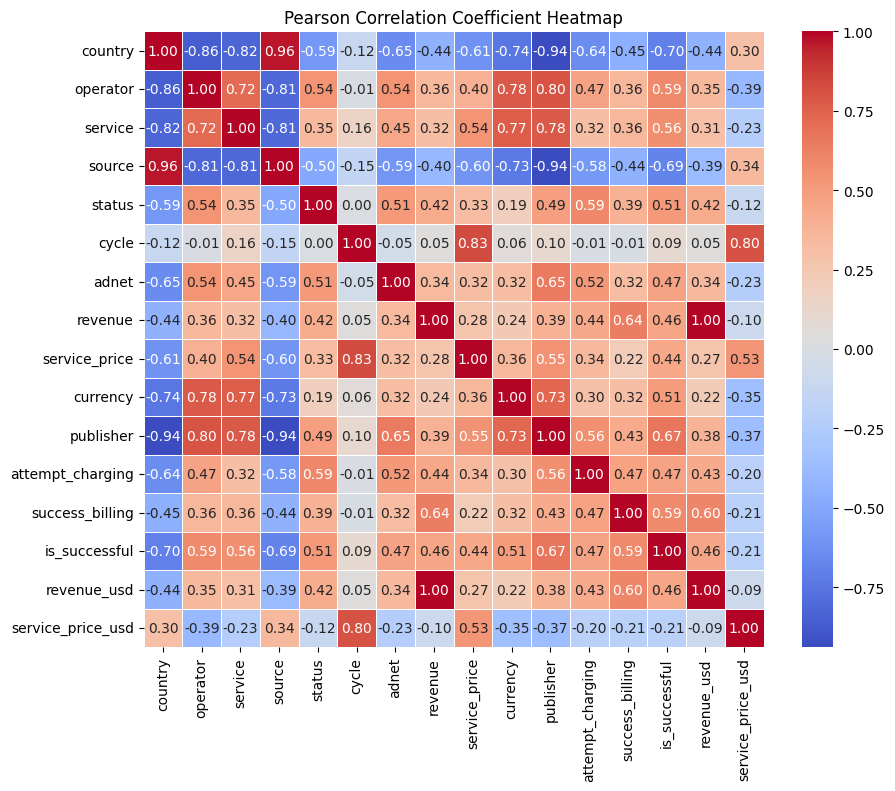

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# Specify the ordinal categorical columns to be encoded
categorical_columns = ['country', 'operator', 'source','cycle','adnet','service', 'currency','publisher']

# Check if the specified columns exist in the DataFrame
missing_columns = set(categorical_columns) - set(df.columns)
if missing_columns:
    print(f"Error: The following columns do not exist in the DataFrame: {missing_columns}")
else:
    # Create a copy of the DataFrame for encoding
    df_encoded = df.copy()

    # Convert specified columns to string type before encoding
    for column in categorical_columns:
        df_encoded[column] = df_encoded[column].astype(str)

    # Apply LabelEncoder to categorical columns
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

    # Filter out non-numeric columns before calculating correlation
    df_numeric = df_encoded.select_dtypes(include=['number'])

    # Calculate the Pearson correlation matrix
    corr_matrix = df_numeric.corr()

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
    plt.title('Pearson Correlation Coefficient Heatmap')
    plt.show()


In [82]:
# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# Print the list of column names
print("Column Names:")
print(df.columns)

Column Names:
Index(['country', 'operator', 'service', 'source', 'status', 'cycle', 'adnet',
       'revenue', 'subs_date', 'renewal_date', 'freemium_end_date',
       'unsubs_from', 'unsubs_date', 'service_price', 'currency',
       'profile_status', 'publisher', 'attempt_charging', 'success_billing',
       'combined_created_date', 'is_successful', 'revenue_usd',
       'service_price_usd'],
      dtype='object')


In [44]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# Create a contingency table
contingency_table = pd.crosstab(df['country'], df['currency'])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square Statistic: 924114.0
P-value: 0.0


In [45]:
print("Unique countries:", df['country'].unique())
print("Unique currencies:", df['currency'].unique())

Unique countries: ['TH' 'SN' 'LA' 'OM']
Unique currencies: ['BATH' 'XOF' 'LAK' 'Rial']


In [46]:
# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# Filter data for 'TH' country and 'BATH' currency
subset_data = df[(df['country'] == 'TH') & (df['currency'] == 'BATH')]

# Display the subset data
print(subset_data)

       country operator    service source  status  cycle    adnet  revenue  \
0           TH      ais  459505104    sms       0  daily  Unknown        0   
1           TH      ais  459505104    sms       0  daily  Unknown        0   
2           TH      ais  459505106    ivr       0      1  Unknown        6   
3           TH      ais  459505105    wap       0  daily     star        0   
4           TH      ais  459505104    sms       0  daily  Unknown        0   
...        ...      ...        ...    ...     ...    ...      ...      ...   
199995      TH      ais  459505105    sms       0  daily  Unknown        0   
199996      TH      ais  459505104    sms       0  daily  Unknown        0   
199997      TH      ais  459505104    sms       0  daily  Unknown        0   
199998      TH      ais  459505106    sms       0  daily     star        0   
199999      TH      ais  459505106    sms       0  daily  Unknown        0   

                  subs_date renewal_date  ... service_price cur

In [61]:
# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# Replace NaN values with 0
df_numeric = df.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.fillna(0)

# Choose a specific country, for example, 'TH' (Thailand)
specific_country = 'LA'

# Filter data for the specific country
subset_data = df[df['country'] == specific_country]

# Get unique values in the 'currency' column for the specific country
unique_currencies = subset_data['currency'].unique()

# Display unique currency values
print(f"Unique currencies for {specific_country}: {unique_currencies}")

Unique currencies for LA: ['LAK']


In [66]:
# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# List of columns to convert to numeric
numeric_columns = ['revenue', 'service_price', 'attempt_charging', 'is_successful']

# Convert specified columns to numeric types
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='raise')  # 'raise' to raise an error if conversion fails

In [74]:
# Assuming df is your DataFrame with the specified columns
# Filter out columns starting with 'Unnamed' or 'id'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df.loc[:, ~df.columns.str.startswith('id')]

# List of columns to convert to numeric
numeric_columns = ['revenue', 'service_price', 'attempt_charging', 'is_successful']

# Convert specified columns to numeric types
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [75]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

ValueError: could not convert string to float: 'TH'